In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import numpy as np
from torchvision import datasets, models, transforms
import os
import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image
from torch.utils.data import Dataset,DataLoader

In [2]:
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
# 定义是否使用GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
EPOCH = 10   #遍历数据集次数
pre_epoch = 0  # 定义已经遍历数据集的次数
BATCH_SIZE = 10   #批处理尺寸(batch_size)
LR = 0.0001        #学习率

In [7]:
# 准备数据集并预处理

class MyDataset(Dataset):
    def __init__(self,imageFolderDataset,transform=None,should_invert=True):
        self.imgs = imageFolderDataset.imgs    
        self.transform = transform
        self.should_invert = should_invert
        
    def __getitem__(self, index):
        fn, label = self.imgs[index]
        #print(fn)   图片地址
        #print(label)   图片类别，cat=0，dog=1
        img = Image.open(fn).convert('RGB')
             
        if self.should_invert:
            img = PIL.ImageOps.invert(img)   #invert：图片取反
            
        if self.transform is not None:
            img = self.transform(img) 
            
        return img, label
    
    def __len__(self):
        return len(self.imgs)

transform = transforms.Compose([transforms.CenterCrop(128),
                                transforms.ToTensor()
                                ])

train_dir = 'D:\数据库\palmdata\iitd'

train_dataset=torchvision.datasets.ImageFolder(root=train_dir)

training_set=MyDataset(imageFolderDataset=train_dataset,transform=transform,should_invert=False)

training_loader = DataLoader(training_set,shuffle=True,batch_size=BATCH_SIZE,num_workers=0)

In [8]:
print(next(iter(training_loader))[0].shape)  #torch.Size([128, 3, 128, 128])
print(next(iter(training_loader))[1].shape)  #torch.Size([128])

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



# 可视化

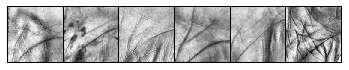

[331  90  27 358 268  94]


In [5]:
def show_img(img0,title=None):
    img=img0.numpy()
    plt.axis("off")
    if title:
        plt.text(75, 8, text, style='italic',fontweight='bold',bbox={'facecolor':'white', 'alpha':0.8, 'pad':10})
    plt.imshow(np.transpose(img,(1,2,0)))
    plt.show()
    
visual_dataloader=DataLoader(training_set,shuffle=True,batch_size=6)
x,y=next(iter(visual_dataloader)) 
show_img(torchvision.utils.make_grid(x, nrow=6))
print(y.numpy())

# 调用与训练的vgg16

In [6]:
class VGGNet(nn.Module):
    def __init__(self, num_classes=460):   # num_classes，此处为 二分类值为2
        super(VGGNet, self).__init__()
        net = models.vgg16(pretrained=True)   # 从预训练模型加载VGG16网络参数
        net.classifier = nn.Sequential()  # 将分类层置空，下面将改变我们的分类层
        self.features = net  # 保留VGG16的特征层
        self.classifier = nn.Sequential(    # 定义自己的分类层
                nn.Linear(512 * 7 * 7, 1024),  #512 * 7 * 7不能改变 ，由VGG16网络决定的，第二个参数为神经元个数可以微调
                nn.ReLU(True),
                nn.Dropout(0.3),
                nn.Linear(1024, 1024),
                nn.ReLU(True),
                nn.Dropout(0.3),
                nn.Linear(1024, num_classes),
        )

    def forward(self, x):
        x = self.features(x) # 预训练提供的提取特征的部分
        x = x.view(x.size(0), -1)
        x = self.classifier(x) # 自定义的分类部分
        return x
net = VGGNet().to(device)
print(net)

VGGNet(
  (features): VGG(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): ReLU(inplace)
      (16): MaxPool2d(kernel_size=2, stride=2

In [7]:
from collections.abc import Iterable
def set_freeze_by_names(model, layer_names, freeze=True):
    if not isinstance(layer_names, Iterable):
        layer_names = [layer_names]
    for name, child in model.named_children():
        if name not in layer_names:
            continue
        for param in child.parameters():
            param.requires_grad = not freeze

def freeze_by_names(model, layer_names):   #冻结某层
    set_freeze_by_names(model, layer_names, True)

def unfreeze_by_names(model, layer_names):  #解冻某层
    set_freeze_by_names(model, layer_names, False)
    
freeze_by_names(net,['features','avgpool','classifier'])
unfreeze_by_names(net,'classifier')

In [8]:
optimizer = optim.Adam(net.parameters(), lr=0.0001)
criterion = nn.CrossEntropyLoss()
criterion.to(device=device)

CrossEntropyLoss()

In [9]:
y_predict = []
y_true = []

from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

# 训练模型

In [10]:
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
print("Start Training!")  # 定义遍历数据集的次数
for epoch in range(pre_epoch, EPOCH):
    print('\nEpoch: %d' % (epoch + 1))
    net.train()
    sum_loss = 0.0
    correct = 0.0
    total = 0.0
    
    for i, data in enumerate(training_loader, 0):
        # 准备数据
        length = len(training_loader)
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        
        # forward + backward
        #with torch.no_grad():
        outputs = net(inputs)
        optimizer.zero_grad()
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # 每训练1个batch打印一次loss和准确率
        sum_loss += loss.item()
        
        # 使用Top5分类
        maxk = max((1,1))
        label_resize = labels.view(-1, 1)
        _, predicted = outputs.topk(maxk, 1, True, True)
        total += labels.size(0)
        correct += torch.eq(predicted, label_resize).cpu().sum().float().item()
            
        print('[epoch:%d, iter:%d] Loss: %.03f | Acc: %.3f%% '% (epoch + 1, (i + 1 + epoch * length), sum_loss / (i + 1), 100. * correct / total))
    
#     #每训练完一个epoch测试一下准确率
#     print("Waiting Test!")
#     with torch.no_grad():
#         correct = 0
#         total = 0
#         for data in valing_loader:
#             net.eval()
#             images, labels = data
#             images, labels = images.to(device), labels.to(device)
#             outputs = net(images)
#             # 取得分最高的那个类 (outputs.data的索引号)
            
#             maxk = max((1,5))
#             label_resize = labels.view(-1, 1)
#             _, predicted = outputs.topk(maxk, 1, True, True)
#             total += labels.size(0)
#             correct += torch.eq(predicted, label_resize).cpu().sum().float().item()
            
#             y_predict.append(predicted)
#             y_true.append(labels)
#         print('测试分类准确率为：%.3f%%' % (100 * correct / total))
#         acc = 100. * correct / total
# print("Training Finished, TotalEPOCH=%d" % EPOCH)

Start Training!

Epoch: 1
[epoch:1, iter:1] Loss: 6.122 | Acc: 10.000% 
[epoch:1, iter:2] Loss: 6.136 | Acc: 5.000% 
[epoch:1, iter:3] Loss: 6.144 | Acc: 3.333% 
[epoch:1, iter:4] Loss: 6.128 | Acc: 2.500% 
[epoch:1, iter:5] Loss: 6.128 | Acc: 2.000% 
[epoch:1, iter:6] Loss: 6.135 | Acc: 1.667% 
[epoch:1, iter:7] Loss: 6.130 | Acc: 2.857% 
[epoch:1, iter:8] Loss: 6.126 | Acc: 2.500% 
[epoch:1, iter:9] Loss: 6.129 | Acc: 2.222% 
[epoch:1, iter:10] Loss: 6.124 | Acc: 2.000% 
[epoch:1, iter:11] Loss: 6.131 | Acc: 1.818% 
[epoch:1, iter:12] Loss: 6.130 | Acc: 2.500% 
[epoch:1, iter:13] Loss: 6.129 | Acc: 2.308% 
[epoch:1, iter:14] Loss: 6.133 | Acc: 2.143% 
[epoch:1, iter:15] Loss: 6.138 | Acc: 2.000% 
[epoch:1, iter:16] Loss: 6.138 | Acc: 1.875% 
[epoch:1, iter:17] Loss: 6.142 | Acc: 1.765% 
[epoch:1, iter:18] Loss: 6.149 | Acc: 1.667% 
[epoch:1, iter:19] Loss: 6.149 | Acc: 1.579% 
[epoch:1, iter:20] Loss: 6.150 | Acc: 1.500% 
[epoch:1, iter:21] Loss: 6.150 | Acc: 1.429% 
[epoch:1, iter:2

[epoch:1, iter:178] Loss: 6.145 | Acc: 0.674% 
[epoch:1, iter:179] Loss: 6.144 | Acc: 0.670% 
[epoch:1, iter:180] Loss: 6.145 | Acc: 0.667% 
[epoch:1, iter:181] Loss: 6.144 | Acc: 0.663% 
[epoch:1, iter:182] Loss: 6.144 | Acc: 0.659% 
[epoch:1, iter:183] Loss: 6.144 | Acc: 0.656% 
[epoch:1, iter:184] Loss: 6.144 | Acc: 0.652% 
[epoch:1, iter:185] Loss: 6.144 | Acc: 0.649% 
[epoch:1, iter:186] Loss: 6.144 | Acc: 0.645% 
[epoch:1, iter:187] Loss: 6.143 | Acc: 0.642% 
[epoch:1, iter:188] Loss: 6.143 | Acc: 0.638% 
[epoch:1, iter:189] Loss: 6.143 | Acc: 0.635% 
[epoch:1, iter:190] Loss: 6.144 | Acc: 0.632% 
[epoch:1, iter:191] Loss: 6.144 | Acc: 0.628% 
[epoch:1, iter:192] Loss: 6.144 | Acc: 0.625% 
[epoch:1, iter:193] Loss: 6.144 | Acc: 0.622% 
[epoch:1, iter:194] Loss: 6.143 | Acc: 0.619% 
[epoch:1, iter:195] Loss: 6.143 | Acc: 0.615% 
[epoch:1, iter:196] Loss: 6.143 | Acc: 0.612% 
[epoch:1, iter:197] Loss: 6.143 | Acc: 0.609% 
[epoch:1, iter:198] Loss: 6.143 | Acc: 0.606% 
[epoch:1, ite

[epoch:2, iter:353] Loss: 5.780 | Acc: 4.348% 
[epoch:2, iter:354] Loss: 5.772 | Acc: 4.409% 
[epoch:2, iter:355] Loss: 5.769 | Acc: 4.362% 
[epoch:2, iter:356] Loss: 5.765 | Acc: 4.421% 
[epoch:2, iter:357] Loss: 5.764 | Acc: 4.375% 
[epoch:2, iter:358] Loss: 5.764 | Acc: 4.330% 
[epoch:2, iter:359] Loss: 5.765 | Acc: 4.286% 
[epoch:2, iter:360] Loss: 5.762 | Acc: 4.242% 
[epoch:2, iter:361] Loss: 5.761 | Acc: 4.200% 
[epoch:2, iter:362] Loss: 5.760 | Acc: 4.158% 
[epoch:2, iter:363] Loss: 5.757 | Acc: 4.314% 
[epoch:2, iter:364] Loss: 5.758 | Acc: 4.369% 
[epoch:2, iter:365] Loss: 5.756 | Acc: 4.327% 
[epoch:2, iter:366] Loss: 5.752 | Acc: 4.286% 
[epoch:2, iter:367] Loss: 5.752 | Acc: 4.245% 
[epoch:2, iter:368] Loss: 5.752 | Acc: 4.206% 
[epoch:2, iter:369] Loss: 5.744 | Acc: 4.352% 
[epoch:2, iter:370] Loss: 5.739 | Acc: 4.404% 
[epoch:2, iter:371] Loss: 5.737 | Acc: 4.364% 
[epoch:2, iter:372] Loss: 5.736 | Acc: 4.324% 
[epoch:2, iter:373] Loss: 5.735 | Acc: 4.286% 
[epoch:2, ite

[epoch:3, iter:528] Loss: 3.673 | Acc: 38.333% 
[epoch:3, iter:529] Loss: 3.677 | Acc: 37.143% 
[epoch:3, iter:530] Loss: 3.657 | Acc: 38.750% 
[epoch:3, iter:531] Loss: 3.730 | Acc: 34.444% 
[epoch:3, iter:532] Loss: 3.776 | Acc: 32.000% 
[epoch:3, iter:533] Loss: 3.790 | Acc: 32.727% 
[epoch:3, iter:534] Loss: 3.755 | Acc: 32.500% 
[epoch:3, iter:535] Loss: 3.780 | Acc: 31.538% 
[epoch:3, iter:536] Loss: 3.749 | Acc: 32.143% 
[epoch:3, iter:537] Loss: 3.766 | Acc: 30.000% 
[epoch:3, iter:538] Loss: 3.767 | Acc: 30.000% 
[epoch:3, iter:539] Loss: 3.768 | Acc: 29.412% 
[epoch:3, iter:540] Loss: 3.786 | Acc: 28.333% 
[epoch:3, iter:541] Loss: 3.835 | Acc: 27.368% 
[epoch:3, iter:542] Loss: 3.824 | Acc: 27.000% 
[epoch:3, iter:543] Loss: 3.820 | Acc: 27.143% 
[epoch:3, iter:544] Loss: 3.820 | Acc: 27.727% 
[epoch:3, iter:545] Loss: 3.794 | Acc: 28.696% 
[epoch:3, iter:546] Loss: 3.802 | Acc: 28.750% 
[epoch:3, iter:547] Loss: 3.806 | Acc: 27.600% 
[epoch:3, iter:548] Loss: 3.815 | Acc: 2

[epoch:3, iter:699] Loss: 3.380 | Acc: 32.712% 
[epoch:3, iter:700] Loss: 3.375 | Acc: 32.753% 
[epoch:3, iter:701] Loss: 3.371 | Acc: 32.793% 
[epoch:3, iter:702] Loss: 3.369 | Acc: 32.833% 
[epoch:3, iter:703] Loss: 3.362 | Acc: 32.983% 
[epoch:3, iter:704] Loss: 3.360 | Acc: 32.967% 
[epoch:3, iter:705] Loss: 3.359 | Acc: 32.896% 
[epoch:3, iter:706] Loss: 3.352 | Acc: 33.043% 
[epoch:3, iter:707] Loss: 3.351 | Acc: 33.189% 
[epoch:3, iter:708] Loss: 3.350 | Acc: 33.172% 
[epoch:3, iter:709] Loss: 3.345 | Acc: 33.155% 
[epoch:3, iter:710] Loss: 3.344 | Acc: 33.245% 
[epoch:3, iter:711] Loss: 3.345 | Acc: 33.175% 
[epoch:3, iter:712] Loss: 3.340 | Acc: 33.211% 
[epoch:3, iter:713] Loss: 3.340 | Acc: 33.298% 
[epoch:3, iter:714] Loss: 3.337 | Acc: 33.281% 
[epoch:3, iter:715] Loss: 3.330 | Acc: 33.368% 
[epoch:3, iter:716] Loss: 3.327 | Acc: 33.402% 
[epoch:3, iter:717] Loss: 3.324 | Acc: 33.436% 
[epoch:3, iter:718] Loss: 3.318 | Acc: 33.469% 
[epoch:3, iter:719] Loss: 3.314 | Acc: 3

[epoch:4, iter:870] Loss: 1.878 | Acc: 60.000% 
[epoch:4, iter:871] Loss: 1.868 | Acc: 60.341% 
[epoch:4, iter:872] Loss: 1.862 | Acc: 60.562% 
[epoch:4, iter:873] Loss: 1.860 | Acc: 60.556% 
[epoch:4, iter:874] Loss: 1.858 | Acc: 60.549% 
[epoch:4, iter:875] Loss: 1.852 | Acc: 60.652% 
[epoch:4, iter:876] Loss: 1.855 | Acc: 60.323% 
[epoch:4, iter:877] Loss: 1.859 | Acc: 60.319% 
[epoch:4, iter:878] Loss: 1.867 | Acc: 60.105% 
[epoch:4, iter:879] Loss: 1.866 | Acc: 60.208% 
[epoch:4, iter:880] Loss: 1.861 | Acc: 60.206% 
[epoch:4, iter:881] Loss: 1.858 | Acc: 60.306% 
[epoch:4, iter:882] Loss: 1.850 | Acc: 60.505% 
[epoch:4, iter:883] Loss: 1.854 | Acc: 60.500% 
[epoch:4, iter:884] Loss: 1.859 | Acc: 60.297% 
[epoch:4, iter:885] Loss: 1.855 | Acc: 60.490% 
[epoch:4, iter:886] Loss: 1.849 | Acc: 60.583% 
[epoch:4, iter:887] Loss: 1.847 | Acc: 60.769% 
[epoch:4, iter:888] Loss: 1.846 | Acc: 60.857% 
[epoch:4, iter:889] Loss: 1.840 | Acc: 61.038% 
[epoch:4, iter:890] Loss: 1.834 | Acc: 6

[epoch:4, iter:1040] Loss: 1.662 | Acc: 63.813% 
[epoch:4, iter:1041] Loss: 1.661 | Acc: 63.837% 
[epoch:4, iter:1042] Loss: 1.662 | Acc: 63.822% 
[epoch:4, iter:1043] Loss: 1.661 | Acc: 63.769% 
[epoch:4, iter:1044] Loss: 1.667 | Acc: 63.745% 

Epoch: 5
[epoch:5, iter:1045] Loss: 0.908 | Acc: 80.000% 
[epoch:5, iter:1046] Loss: 0.941 | Acc: 80.000% 
[epoch:5, iter:1047] Loss: 1.127 | Acc: 83.333% 
[epoch:5, iter:1048] Loss: 1.284 | Acc: 82.500% 
[epoch:5, iter:1049] Loss: 1.239 | Acc: 80.000% 
[epoch:5, iter:1050] Loss: 1.245 | Acc: 78.333% 
[epoch:5, iter:1051] Loss: 1.248 | Acc: 74.286% 
[epoch:5, iter:1052] Loss: 1.247 | Acc: 75.000% 
[epoch:5, iter:1053] Loss: 1.206 | Acc: 76.667% 
[epoch:5, iter:1054] Loss: 1.190 | Acc: 77.000% 
[epoch:5, iter:1055] Loss: 1.158 | Acc: 77.273% 
[epoch:5, iter:1056] Loss: 1.142 | Acc: 76.667% 
[epoch:5, iter:1057] Loss: 1.153 | Acc: 76.923% 
[epoch:5, iter:1058] Loss: 1.153 | Acc: 77.857% 
[epoch:5, iter:1059] Loss: 1.147 | Acc: 77.333% 
[epoch:5, 

[epoch:5, iter:1207] Loss: 0.988 | Acc: 79.202% 
[epoch:5, iter:1208] Loss: 0.990 | Acc: 79.146% 
[epoch:5, iter:1209] Loss: 0.989 | Acc: 79.152% 
[epoch:5, iter:1210] Loss: 0.991 | Acc: 79.157% 
[epoch:5, iter:1211] Loss: 0.990 | Acc: 79.162% 
[epoch:5, iter:1212] Loss: 0.991 | Acc: 79.048% 
[epoch:5, iter:1213] Loss: 0.992 | Acc: 78.994% 
[epoch:5, iter:1214] Loss: 0.991 | Acc: 79.000% 
[epoch:5, iter:1215] Loss: 0.993 | Acc: 79.064% 
[epoch:5, iter:1216] Loss: 0.990 | Acc: 79.186% 
[epoch:5, iter:1217] Loss: 0.989 | Acc: 79.191% 
[epoch:5, iter:1218] Loss: 0.986 | Acc: 79.310% 
[epoch:5, iter:1219] Loss: 0.986 | Acc: 79.257% 
[epoch:5, iter:1220] Loss: 0.986 | Acc: 79.261% 
[epoch:5, iter:1221] Loss: 0.987 | Acc: 79.209% 
[epoch:5, iter:1222] Loss: 0.989 | Acc: 79.157% 
[epoch:5, iter:1223] Loss: 0.988 | Acc: 79.218% 
[epoch:5, iter:1224] Loss: 0.987 | Acc: 79.222% 
[epoch:5, iter:1225] Loss: 0.985 | Acc: 79.282% 
[epoch:5, iter:1226] Loss: 0.985 | Acc: 79.231% 
[epoch:5, iter:1227]

[epoch:6, iter:1374] Loss: 0.604 | Acc: 89.565% 
[epoch:6, iter:1375] Loss: 0.605 | Acc: 89.571% 
[epoch:6, iter:1376] Loss: 0.598 | Acc: 89.718% 
[epoch:6, iter:1377] Loss: 0.598 | Acc: 89.583% 
[epoch:6, iter:1378] Loss: 0.592 | Acc: 89.726% 
[epoch:6, iter:1379] Loss: 0.595 | Acc: 89.459% 
[epoch:6, iter:1380] Loss: 0.599 | Acc: 89.333% 
[epoch:6, iter:1381] Loss: 0.599 | Acc: 89.211% 
[epoch:6, iter:1382] Loss: 0.600 | Acc: 89.091% 
[epoch:6, iter:1383] Loss: 0.597 | Acc: 89.103% 
[epoch:6, iter:1384] Loss: 0.595 | Acc: 89.114% 
[epoch:6, iter:1385] Loss: 0.606 | Acc: 88.750% 
[epoch:6, iter:1386] Loss: 0.606 | Acc: 88.765% 
[epoch:6, iter:1387] Loss: 0.610 | Acc: 88.537% 
[epoch:6, iter:1388] Loss: 0.606 | Acc: 88.675% 
[epoch:6, iter:1389] Loss: 0.604 | Acc: 88.690% 
[epoch:6, iter:1390] Loss: 0.600 | Acc: 88.824% 
[epoch:6, iter:1391] Loss: 0.600 | Acc: 88.837% 
[epoch:6, iter:1392] Loss: 0.598 | Acc: 88.966% 
[epoch:6, iter:1393] Loss: 0.602 | Acc: 88.977% 
[epoch:6, iter:1394]

[epoch:6, iter:1542] Loss: 0.622 | Acc: 87.511% 
[epoch:6, iter:1543] Loss: 0.621 | Acc: 87.563% 
[epoch:6, iter:1544] Loss: 0.623 | Acc: 87.490% 
[epoch:6, iter:1545] Loss: 0.621 | Acc: 87.542% 
[epoch:6, iter:1546] Loss: 0.621 | Acc: 87.510% 
[epoch:6, iter:1547] Loss: 0.622 | Acc: 87.438% 
[epoch:6, iter:1548] Loss: 0.621 | Acc: 87.449% 
[epoch:6, iter:1549] Loss: 0.620 | Acc: 87.459% 
[epoch:6, iter:1550] Loss: 0.620 | Acc: 87.469% 
[epoch:6, iter:1551] Loss: 0.619 | Acc: 87.480% 
[epoch:6, iter:1552] Loss: 0.618 | Acc: 87.530% 
[epoch:6, iter:1553] Loss: 0.618 | Acc: 87.581% 
[epoch:6, iter:1554] Loss: 0.617 | Acc: 87.631% 
[epoch:6, iter:1555] Loss: 0.617 | Acc: 87.600% 
[epoch:6, iter:1556] Loss: 0.618 | Acc: 87.570% 
[epoch:6, iter:1557] Loss: 0.619 | Acc: 87.579% 
[epoch:6, iter:1558] Loss: 0.619 | Acc: 87.589% 
[epoch:6, iter:1559] Loss: 0.618 | Acc: 87.559% 
[epoch:6, iter:1560] Loss: 0.619 | Acc: 87.529% 
[epoch:6, iter:1561] Loss: 0.622 | Acc: 87.500% 
[epoch:6, iter:1562]

[epoch:7, iter:1709] Loss: 0.435 | Acc: 91.329% 
[epoch:7, iter:1710] Loss: 0.433 | Acc: 91.389% 
[epoch:7, iter:1711] Loss: 0.432 | Acc: 91.448% 
[epoch:7, iter:1712] Loss: 0.430 | Acc: 91.507% 
[epoch:7, iter:1713] Loss: 0.432 | Acc: 91.497% 
[epoch:7, iter:1714] Loss: 0.430 | Acc: 91.554% 
[epoch:7, iter:1715] Loss: 0.430 | Acc: 91.544% 
[epoch:7, iter:1716] Loss: 0.429 | Acc: 91.600% 
[epoch:7, iter:1717] Loss: 0.430 | Acc: 91.457% 
[epoch:7, iter:1718] Loss: 0.431 | Acc: 91.447% 
[epoch:7, iter:1719] Loss: 0.430 | Acc: 91.503% 
[epoch:7, iter:1720] Loss: 0.431 | Acc: 91.494% 
[epoch:7, iter:1721] Loss: 0.435 | Acc: 91.419% 
[epoch:7, iter:1722] Loss: 0.434 | Acc: 91.474% 
[epoch:7, iter:1723] Loss: 0.432 | Acc: 91.529% 
[epoch:7, iter:1724] Loss: 0.432 | Acc: 91.519% 
[epoch:7, iter:1725] Loss: 0.430 | Acc: 91.572% 
[epoch:7, iter:1726] Loss: 0.429 | Acc: 91.625% 
[epoch:7, iter:1727] Loss: 0.431 | Acc: 91.491% 
[epoch:7, iter:1728] Loss: 0.429 | Acc: 91.543% 
[epoch:7, iter:1729]

[epoch:8, iter:1876] Loss: 0.341 | Acc: 93.469% 
[epoch:8, iter:1877] Loss: 0.344 | Acc: 93.400% 
[epoch:8, iter:1878] Loss: 0.342 | Acc: 93.333% 
[epoch:8, iter:1879] Loss: 0.342 | Acc: 93.269% 
[epoch:8, iter:1880] Loss: 0.338 | Acc: 93.396% 
[epoch:8, iter:1881] Loss: 0.336 | Acc: 93.333% 
[epoch:8, iter:1882] Loss: 0.334 | Acc: 93.273% 
[epoch:8, iter:1883] Loss: 0.337 | Acc: 93.214% 
[epoch:8, iter:1884] Loss: 0.343 | Acc: 93.333% 
[epoch:8, iter:1885] Loss: 0.343 | Acc: 93.276% 
[epoch:8, iter:1886] Loss: 0.343 | Acc: 93.220% 
[epoch:8, iter:1887] Loss: 0.345 | Acc: 93.000% 
[epoch:8, iter:1888] Loss: 0.340 | Acc: 93.115% 
[epoch:8, iter:1889] Loss: 0.340 | Acc: 93.065% 
[epoch:8, iter:1890] Loss: 0.338 | Acc: 93.175% 
[epoch:8, iter:1891] Loss: 0.335 | Acc: 93.281% 
[epoch:8, iter:1892] Loss: 0.336 | Acc: 93.077% 
[epoch:8, iter:1893] Loss: 0.333 | Acc: 93.182% 
[epoch:8, iter:1894] Loss: 0.331 | Acc: 93.284% 
[epoch:8, iter:1895] Loss: 0.331 | Acc: 93.235% 
[epoch:8, iter:1896]

[epoch:8, iter:2044] Loss: 0.291 | Acc: 94.654% 
[epoch:8, iter:2045] Loss: 0.291 | Acc: 94.633% 
[epoch:8, iter:2046] Loss: 0.293 | Acc: 94.521% 
[epoch:8, iter:2047] Loss: 0.293 | Acc: 94.545% 
[epoch:8, iter:2048] Loss: 0.293 | Acc: 94.525% 
[epoch:8, iter:2049] Loss: 0.293 | Acc: 94.550% 
[epoch:8, iter:2050] Loss: 0.293 | Acc: 94.574% 
[epoch:8, iter:2051] Loss: 0.293 | Acc: 94.554% 
[epoch:8, iter:2052] Loss: 0.293 | Acc: 94.578% 
[epoch:8, iter:2053] Loss: 0.293 | Acc: 94.558% 
[epoch:8, iter:2054] Loss: 0.292 | Acc: 94.581% 
[epoch:8, iter:2055] Loss: 0.292 | Acc: 94.605% 
[epoch:8, iter:2056] Loss: 0.292 | Acc: 94.629% 
[epoch:8, iter:2057] Loss: 0.293 | Acc: 94.565% 
[epoch:8, iter:2058] Loss: 0.293 | Acc: 94.589% 
[epoch:8, iter:2059] Loss: 0.292 | Acc: 94.612% 
[epoch:8, iter:2060] Loss: 0.292 | Acc: 94.635% 
[epoch:8, iter:2061] Loss: 0.291 | Acc: 94.658% 
[epoch:8, iter:2062] Loss: 0.291 | Acc: 94.681% 
[epoch:8, iter:2063] Loss: 0.292 | Acc: 94.661% 
[epoch:8, iter:2064]

[epoch:9, iter:2211] Loss: 0.209 | Acc: 97.073% 
[epoch:9, iter:2212] Loss: 0.210 | Acc: 97.016% 
[epoch:9, iter:2213] Loss: 0.209 | Acc: 97.040% 
[epoch:9, iter:2214] Loss: 0.208 | Acc: 97.063% 
[epoch:9, iter:2215] Loss: 0.207 | Acc: 97.087% 
[epoch:9, iter:2216] Loss: 0.206 | Acc: 97.109% 
[epoch:9, iter:2217] Loss: 0.208 | Acc: 96.977% 
[epoch:9, iter:2218] Loss: 0.207 | Acc: 97.000% 
[epoch:9, iter:2219] Loss: 0.210 | Acc: 96.947% 
[epoch:9, iter:2220] Loss: 0.209 | Acc: 96.970% 
[epoch:9, iter:2221] Loss: 0.211 | Acc: 96.917% 
[epoch:9, iter:2222] Loss: 0.211 | Acc: 96.940% 
[epoch:9, iter:2223] Loss: 0.211 | Acc: 96.889% 
[epoch:9, iter:2224] Loss: 0.211 | Acc: 96.912% 
[epoch:9, iter:2225] Loss: 0.211 | Acc: 96.934% 
[epoch:9, iter:2226] Loss: 0.211 | Acc: 96.957% 
[epoch:9, iter:2227] Loss: 0.210 | Acc: 96.978% 
[epoch:9, iter:2228] Loss: 0.210 | Acc: 96.929% 
[epoch:9, iter:2229] Loss: 0.212 | Acc: 96.809% 
[epoch:9, iter:2230] Loss: 0.212 | Acc: 96.831% 
[epoch:9, iter:2231]

[epoch:10, iter:2378] Loss: 0.173 | Acc: 97.586% 
[epoch:10, iter:2379] Loss: 0.168 | Acc: 97.667% 
[epoch:10, iter:2380] Loss: 0.167 | Acc: 97.742% 
[epoch:10, iter:2381] Loss: 0.169 | Acc: 97.812% 
[epoch:10, iter:2382] Loss: 0.168 | Acc: 97.879% 
[epoch:10, iter:2383] Loss: 0.167 | Acc: 97.941% 
[epoch:10, iter:2384] Loss: 0.166 | Acc: 98.000% 
[epoch:10, iter:2385] Loss: 0.168 | Acc: 97.778% 
[epoch:10, iter:2386] Loss: 0.165 | Acc: 97.838% 
[epoch:10, iter:2387] Loss: 0.163 | Acc: 97.895% 
[epoch:10, iter:2388] Loss: 0.163 | Acc: 97.949% 
[epoch:10, iter:2389] Loss: 0.162 | Acc: 98.000% 
[epoch:10, iter:2390] Loss: 0.160 | Acc: 98.049% 
[epoch:10, iter:2391] Loss: 0.160 | Acc: 98.095% 
[epoch:10, iter:2392] Loss: 0.163 | Acc: 97.907% 
[epoch:10, iter:2393] Loss: 0.166 | Acc: 97.500% 
[epoch:10, iter:2394] Loss: 0.163 | Acc: 97.556% 
[epoch:10, iter:2395] Loss: 0.161 | Acc: 97.609% 
[epoch:10, iter:2396] Loss: 0.160 | Acc: 97.660% 
[epoch:10, iter:2397] Loss: 0.165 | Acc: 97.500% 


[epoch:10, iter:2542] Loss: 0.148 | Acc: 97.876% 
[epoch:10, iter:2543] Loss: 0.148 | Acc: 97.887% 
[epoch:10, iter:2544] Loss: 0.148 | Acc: 97.897% 
[epoch:10, iter:2545] Loss: 0.147 | Acc: 97.908% 
[epoch:10, iter:2546] Loss: 0.147 | Acc: 97.919% 
[epoch:10, iter:2547] Loss: 0.147 | Acc: 97.929% 
[epoch:10, iter:2548] Loss: 0.147 | Acc: 97.940% 
[epoch:10, iter:2549] Loss: 0.147 | Acc: 97.950% 
[epoch:10, iter:2550] Loss: 0.146 | Acc: 97.960% 
[epoch:10, iter:2551] Loss: 0.146 | Acc: 97.970% 
[epoch:10, iter:2552] Loss: 0.147 | Acc: 97.931% 
[epoch:10, iter:2553] Loss: 0.147 | Acc: 97.892% 
[epoch:10, iter:2554] Loss: 0.147 | Acc: 97.902% 
[epoch:10, iter:2555] Loss: 0.147 | Acc: 97.864% 
[epoch:10, iter:2556] Loss: 0.147 | Acc: 97.874% 
[epoch:10, iter:2557] Loss: 0.147 | Acc: 97.885% 
[epoch:10, iter:2558] Loss: 0.146 | Acc: 97.895% 
[epoch:10, iter:2559] Loss: 0.146 | Acc: 97.905% 
[epoch:10, iter:2560] Loss: 0.146 | Acc: 97.867% 
[epoch:10, iter:2561] Loss: 0.147 | Acc: 97.830% 
